# Combine Data (not from prop)

Data has now been filtered for the parcel numbers in the existing dataset. The end goal is to have a dataset with one row for each parcel in which to build the model. **Imputation will occur in a separate notebook!**

However, we can't forget to explore the existing data for trends or insight along the way, as well as engineer features as we see fit.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import datetime as dt

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-1])

tci = pd.read_csv(path+'/data/model_data/tci_2_0.csv',dtype={'Parcel ID':str}, parse_dates=['Date'])

ppns = set(tci['parcel'])
dates = dict(zip(tci.parcel, tci.Date))

print(tci.shape)

(113132, 34)


## Arms length sales

In [2]:
al = pd.read_csv(path+'/data/clean_data/armslength.csv', dtype=str)
al = al.drop_duplicates()

In [3]:
months = dict(zip(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],range(1,13)))

def parse_date(x):
    day = int(x[0:2])
    month = months[x[2:5]]
    year = int(x[5:])
    return dt.datetime(year,month,day)

al['date'] = al.mdate.apply(parse_date)
al = al.sort_values('date')
# al = al[al.date < dt.date(2015,6,1)]

al = al.loc[al.apply(lambda x: x.date < dates[x.PROPERTY_NUMBER], axis=1)]

#### Grantor is mortgagee

In [4]:
# al.loc[al['GRANTOR_IS_MORTGAGEE'].notnull(),'GRANTOR_IS_MORTGAGEE'] = \
#     al.loc[al['GRANTOR_IS_MORTGAGEE'].notnull(),'GRANTOR_IS_MORTGAGEE'].apply(float)

In [5]:
# tem = pd.merge(tci, al.loc[al.date > dt.date(2014,6,1), ['GRANTOR_IS_MORTGAGEE','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').count(), \
#                how='left', left_on='parcel', right_index=True)
# tem.loc[tem['GRANTOR_IS_MORTGAGEE'].isnull(),'GRANTOR_IS_MORTGAGEE'] = 0

# t = tem[['vacant','GRANTOR_IS_MORTGAGEE']].groupby('GRANTOR_IS_MORTGAGEE').agg([len,sum])
# t.vacant['sum']/t.vacant['len']

### Number of records for each parcel

In [6]:
# number of sales per year since 2006

tci = pd.merge(tci, al.loc[al.date > dt.datetime(2006,1,1),['date','PROPERTY_NUMBER']]\
               .groupby('PROPERTY_NUMBER')\
               .agg(lambda x: len(x)\
                    /((dates[x.PROPERTY_NUMBER.iloc[0]] - dt.datetime(2006,1,1)).days/365.0))\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'date':'al_num'})
tci.loc[tci.al_num.isnull(),'al_num'] = 0

In [7]:
# days since most recent sale since 2006

tci = pd.merge(tci, al.loc[al.date > dt.datetime(2006,1,1),['date','PROPERTY_NUMBER']]\
               .groupby('PROPERTY_NUMBER')\
               .last()\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'date':'al_date'})

tci.loc[tci.al_date.isnull(),'al_date'] = dt.datetime(2006,1,1)
tci['al_days'] = tci.apply(lambda x: (x.Date-x.al_date).days, axis=1)


### Flags for Deeds

In [8]:
# def add_deed_fields(field_names):
#     for field_name in field_names:
#         deed_ppns = set(al[al.DEED_TYPE==field_name].PROPERTY_NUMBER)                
#         def get_deed_field(x):
#             if x in deed_ppns:
#                 return 1
#             else:
#                 return 0

#         tci[field_name.lower().replace(' ','_')] = tci['ppn'].apply(get_deed_field)
#     return tci
# tci = add_deed_fields(['QUIT CLAIM DEED', 'WARRANTY DEED', 'LIMITED WARRANTY', 'SURVIVORSHIP DEED','FIDUCIARY DEED'])

### Sale Valid {0, 1, 2}

In [9]:
# al = al.sort('YEAR_OF_SALE')
# al[['SALE_VALID','AMOUNT_PAID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last()

In [10]:
# tci = pd.merge(tci, al[['AMOUNT_PAID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last(), \
#                how='left', left_on='ppn', right_index=True)
# # tci.loc[tci.AMOUNT_PAID.notnull(),'SALE_VALID'] = 1
# # tci.loc[tci.SALE_VALID.isnull(),'SALE_VALID'] = 0

In [11]:
# tci = pd.merge(tci, al[['SALE_VALID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last(), \
#                how='left', left_on='ppn', right_index=True)
# tci.loc[tci.SALE_VALID.notnull(),'SALE_VALID'] = 1
# tci.loc[tci.SALE_VALID.isnull(),'SALE_VALID'] = 0

In [12]:
tci.columns

Index(['parcel', 'vacant', 'Date', 'Survey Category', 'Survey Grade',
       'propsize', 'totusabl', 'tmktval', 'condition13', 'condition14',
       'condition_value13', 'condition_value14', 'style_filtered',
       'ownerocc_value', 'totbldgs', 'yrbuilt_filtered', 'rextwall',
       'vacant_block', 'median_rent', 'property_crimes', 'burglaries',
       'part_one_crimes', 'part_two_crimes', 'bachelors+', 'poverty_rate',
       'median_hh_income', 'white', 'black', 'asian', 'other', 'hispanic',
       'young', 'middle', 'old', 'al_num', 'al_date', 'al_days'],
      dtype='object')

## Transfers

In [14]:
t = pd.read_csv(path+'/data/clean_data/transfers.csv', parse_dates=['mdate'], dtype=str)
t = t.sort_values('mdate', ascending=False)

t = t.loc[t.apply(lambda x: x.mdate < dates[x.PROPERTY_NUMBER], axis=1)]
# t.info()

In [16]:
# days since transfer

days_since_transfer = t.groupby('PROPERTY_NUMBER').first()
days_since_transfer = pd.merge(days_since_transfer[['mdate']], tci[['parcel','Date']], how='left', left_index=True, right_on='parcel')

tci = pd.merge(tci, days_since_transfer[['mdate']], left_on='parcel', right_index=True,how='left')
tci.loc[tci.mdate.isnull(),'mdate'] = dt.datetime(2006,1,1)
tci['mdate'] = tci.apply(lambda x: (x.Date - x.mdate).days, axis=1)
# days_since_transfer = days_since_transfer.set_index('parcel')
tci = tci.rename(columns={'mdate':'t_days'})
# tci.loc[tci.t_days.isnull(),'t_days'] = max(tci.t_days)

In [17]:
# days since sheriff's deed type

recent_t = t[(t.mdate > dt.datetime(2006,1,1)) & (t.DEED_TYPE=='Sheriffs Deed')].groupby('PROPERTY_NUMBER').first()
recent_t = pd.merge(recent_t, tci[['parcel','Date']], how='left', left_index=True, right_on='parcel')
recent_t['t_shf_deed'] = recent_t.apply(lambda x: (x.Date-x.mdate).days, axis=1)
recent_t = recent_t.set_index('parcel')

tci = pd.merge(tci, recent_t[['t_shf_deed']], left_on='parcel',right_index=True, how='left')
tci.loc[tci.t_shf_deed.isnull(),'t_shf_deed'] = max(tci[tci.t_shf_deed.notnull()].t_shf_deed)+1

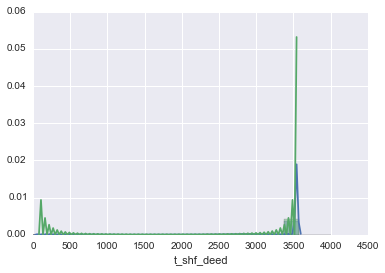

In [18]:
sns.distplot(tci[tci.vacant==1].t_shf_deed,bins=np.linspace(0,4000,20))
sns.distplot(tci[tci.vacant==0].t_shf_deed,bins=np.linspace(0,4000,20));

#### Amount paid

In [19]:
# amount_paid = t.groupby('PROPERTY_NUMBER').first()['AMOUNT_PAID']
# amount_paid = pd.DataFrame(amount_paid)
# amount_paid.columns = ['amount_paid']

# tem = pd.merge(tci, amount_paid, left_on='ppn', right_index=True,how='left')
# # tci[tci.days_since_transfer.isnull()] = max(tci.days_since_transfer)

# plt.hist(tem[tem.vacant==1].amount_paid.values,bins=np.linspace(0,2000,10),alpha=0.5,normed=True)
# plt.hist(tem[tem.vacant==0].amount_paid.values,bins=np.linspace(0,2000,10),alpha=0.5,normed=True);

In [20]:
deeds = list(t.groupby('DEED_TYPE').count().sort_values('mdate',ascending=False).index[0:5])

#### Number of transfers (past 2 years)

In [21]:
tci.columns

Index(['parcel', 'vacant', 'Date', 'Survey Category', 'Survey Grade',
       'propsize', 'totusabl', 'tmktval', 'condition13', 'condition14',
       'condition_value13', 'condition_value14', 'style_filtered',
       'ownerocc_value', 'totbldgs', 'yrbuilt_filtered', 'rextwall',
       'vacant_block', 'median_rent', 'property_crimes', 'burglaries',
       'part_one_crimes', 'part_two_crimes', 'bachelors+', 'poverty_rate',
       'median_hh_income', 'white', 'black', 'asian', 'other', 'hispanic',
       'young', 'middle', 'old', 'al_num', 'al_date', 'al_days', 't_days',
       't_shf_deed'],
      dtype='object')

In [22]:
# number of transfers per year since 2006

tci = pd.merge(tci, t.loc[t.mdate > dt.datetime(2006,1,1), ['PROPERTY_NUMBER','mdate']] \
               .groupby('PROPERTY_NUMBER').count(), how='left', left_on='parcel', right_index=True)
tci['mdate'] = tci['mdate'].fillna(0)
tci = tci.rename(columns = {'mdate':'t_num'})
tci['t_num'] = tci.apply(lambda x: x.t_num/((x.Date - dt.datetime(2006,1,1)).days/365.0), axis = 1)

# tci = pd.merge(tci, t[t.mdate > dt.datetime(2013, 6, 1)].groupby('PROPERTY_NUMBER').count()[['mdate']], how='left', left_on='ppn',right_index=True)
# tci = tci.rename(columns={'mdate':'num_of_transfers'})

#### Last deed type (overall)

In [23]:
# tci = pd.merge(tci, t[['DEED_TYPE', 'PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').first(), \
#          how='left', left_on='ppn',right_index=True)
# tci.DEED_TYPE = tci.DEED_TYPE.apply(lambda x: x if x in deeds else 'Other')

## County Land Bank

In [24]:
lb = pd.read_csv(path+'/data/clean_data/county_lb.csv')

In [25]:
lb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 1099
Data columns (total 16 columns):
parcel            1100 non-null object
disp_status       1100 non-null object
p_source          1084 non-null object
acq_dt            958 non-null object
disp_dt           773 non-null object
assessment        1043 non-null object
demo_status       257 non-null object
rehab_status      810 non-null object
public_status     970 non-null object
s_date            227 non-null object
cclrc_dba_date    57 non-null object
cclrc_dc_date     94 non-null object
ab_proceed_dt     68 non-null object
proceed_date      79 non-null object
cclrc_dcp_date    53 non-null object
out_type          835 non-null object
dtypes: object(16)
memory usage: 146.1+ KB


In [26]:
lb_ppns = set(lb[lb.disp_status=='Acquired'].parcel)

def get_lb(x, lb_ppns):
    if x in lb_ppns:
        return 1
    else:
        return 0

tci['lb_acquired'] = tci['parcel'].apply(lambda x: get_lb(x, lb_ppns))
tci['lb_tax_fc'] = tci['parcel'].apply(lambda x: get_lb(x,set(lb[lb.p_source=='Tax Foreclosure'].parcel)))

## Postal Vacancy

In [27]:
pv = pd.read_csv(path+'/data/clean_data/postal_vacancy.csv', parse_dates=3, index_col=0)
pv.date = pv.date.apply(lambda x: dt.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10])))
pv = pv.sort_values('date',ascending=False)

In [28]:
pv = pv[pv.vindall=='Y']
pv_copy = pv.copy().groupby('PARCEL').count().reset_index()

pv_copy['pv_count'] = pv_copy.apply(lambda x: \
        len(pv[(pv.PARCEL == x.PARCEL) & (pv.date > dates[x.PARCEL]-pd.DateOffset(years=2))]), axis=1)

In [29]:
pv_copy = pv_copy.set_index('PARCEL')

In [30]:
tci = pd.merge(tci, pv_copy[['pv_count']], how='left', left_on='parcel',right_index=True)
tci = tci.rename(columns={'pv_count':'pv_total'})
tci['pv_total'] = tci['pv_total'].fillna(0)

In [31]:
# tci = pd.merge(tci, al[['SALE_VALID','PROPERTY_NUMBER']].groupby('PROPERTY_NUMBER').last(), \
#                how='left', left_on='parcel', right_index=True)

vindall = pv[['PARCEL','vindall']].groupby('PARCEL').first()['vindall']

In [32]:
tci.to_csv(path+'/data/model_data/tci_2_1.csv', index=False)

In [33]:
tci.columns

Index(['parcel', 'vacant', 'Date', 'Survey Category', 'Survey Grade',
       'propsize', 'totusabl', 'tmktval', 'condition13', 'condition14',
       'condition_value13', 'condition_value14', 'style_filtered',
       'ownerocc_value', 'totbldgs', 'yrbuilt_filtered', 'rextwall',
       'vacant_block', 'median_rent', 'property_crimes', 'burglaries',
       'part_one_crimes', 'part_two_crimes', 'bachelors+', 'poverty_rate',
       'median_hh_income', 'white', 'black', 'asian', 'other', 'hispanic',
       'young', 'middle', 'old', 'al_num', 'al_date', 'al_days', 't_days',
       't_shf_deed', 't_num', 'lb_acquired', 'lb_tax_fc', 'pv_total'],
      dtype='object')

In [34]:
tci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113132 entries, 0 to 113131
Data columns (total 43 columns):
parcel               113132 non-null object
vacant               113132 non-null int64
Date                 113132 non-null datetime64[ns]
Survey Category      113132 non-null object
Survey Grade         113132 non-null object
propsize             113132 non-null float64
totusabl             113132 non-null float64
tmktval              113132 non-null float64
condition13          112559 non-null object
condition14          112595 non-null object
condition_value13    113132 non-null float64
condition_value14    113132 non-null float64
style_filtered       113132 non-null object
ownerocc_value       113132 non-null float64
totbldgs             113132 non-null float64
yrbuilt_filtered     113132 non-null float64
rextwall             113132 non-null object
vacant_block         113132 non-null float64
median_rent          113132 non-null float64
property_crimes      113132 non-null